In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/tweet_data.csv')

In [ ]:
df.head()

,Unnamed: 0,ids,sentiment,text
0,0,1467810369,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1,1467810672,0,is upset that he can't update his Facebook by ...
2,2,1467810917,0,@Kenichan I dived many times for the ball. Man...
3,3,1467811184,0,my whole body feels itchy and like its on fire
4,4,1467811193,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
import re
import sys
# from utils import write_status
from nltk.stem.porter import PorterStemmer


def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            # if use_stemmer:
            #     word = str(porter_stemmer.stem(word))
            processed_tweet.append(word)

    return ' '.join(processed_tweet)



In [ ]:
tweet = df['text'].iloc[2]
tw = preprocess_tweet(tweet)
print(tw)

USER_MENTION i dived many times for the ball managed to save the rest go out of bounds


In [ ]:
import numpy as np
df['processed_tweet']= np.vectorize(preprocess_tweet)(df['text'])

In [ ]:
# df['processed_tweet'].iloc[3]
df['processed_tweet'].iloc[100]

'body of missing northern calif girl found police have found the remains of a missing northern california girl URL'

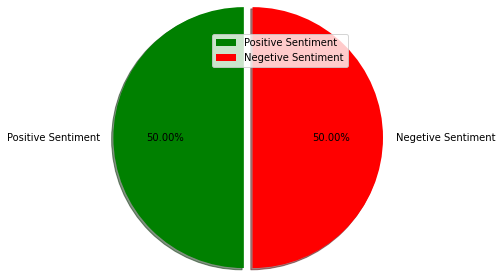

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
slices = [(df['sentiment'] != 0).sum(), (df['sentiment'] == 0).sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
final_vectorized_data = count_vectorizer.fit_transform(df['processed_tweet'])  
final_vectorized_data

<1600000x3646996 sparse matrix of type '<class 'numpy.int64'>'
	with 35951353 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, df['sentiment'],
                                                    test_size=0.2, random_state=69)

In [ ]:

print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (1280000, 3646996)
X_test_shape :  (320000, 3646996)
y_train_shape :  (1280000,)
y_test_shape :  (320000,)


In [ ]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)

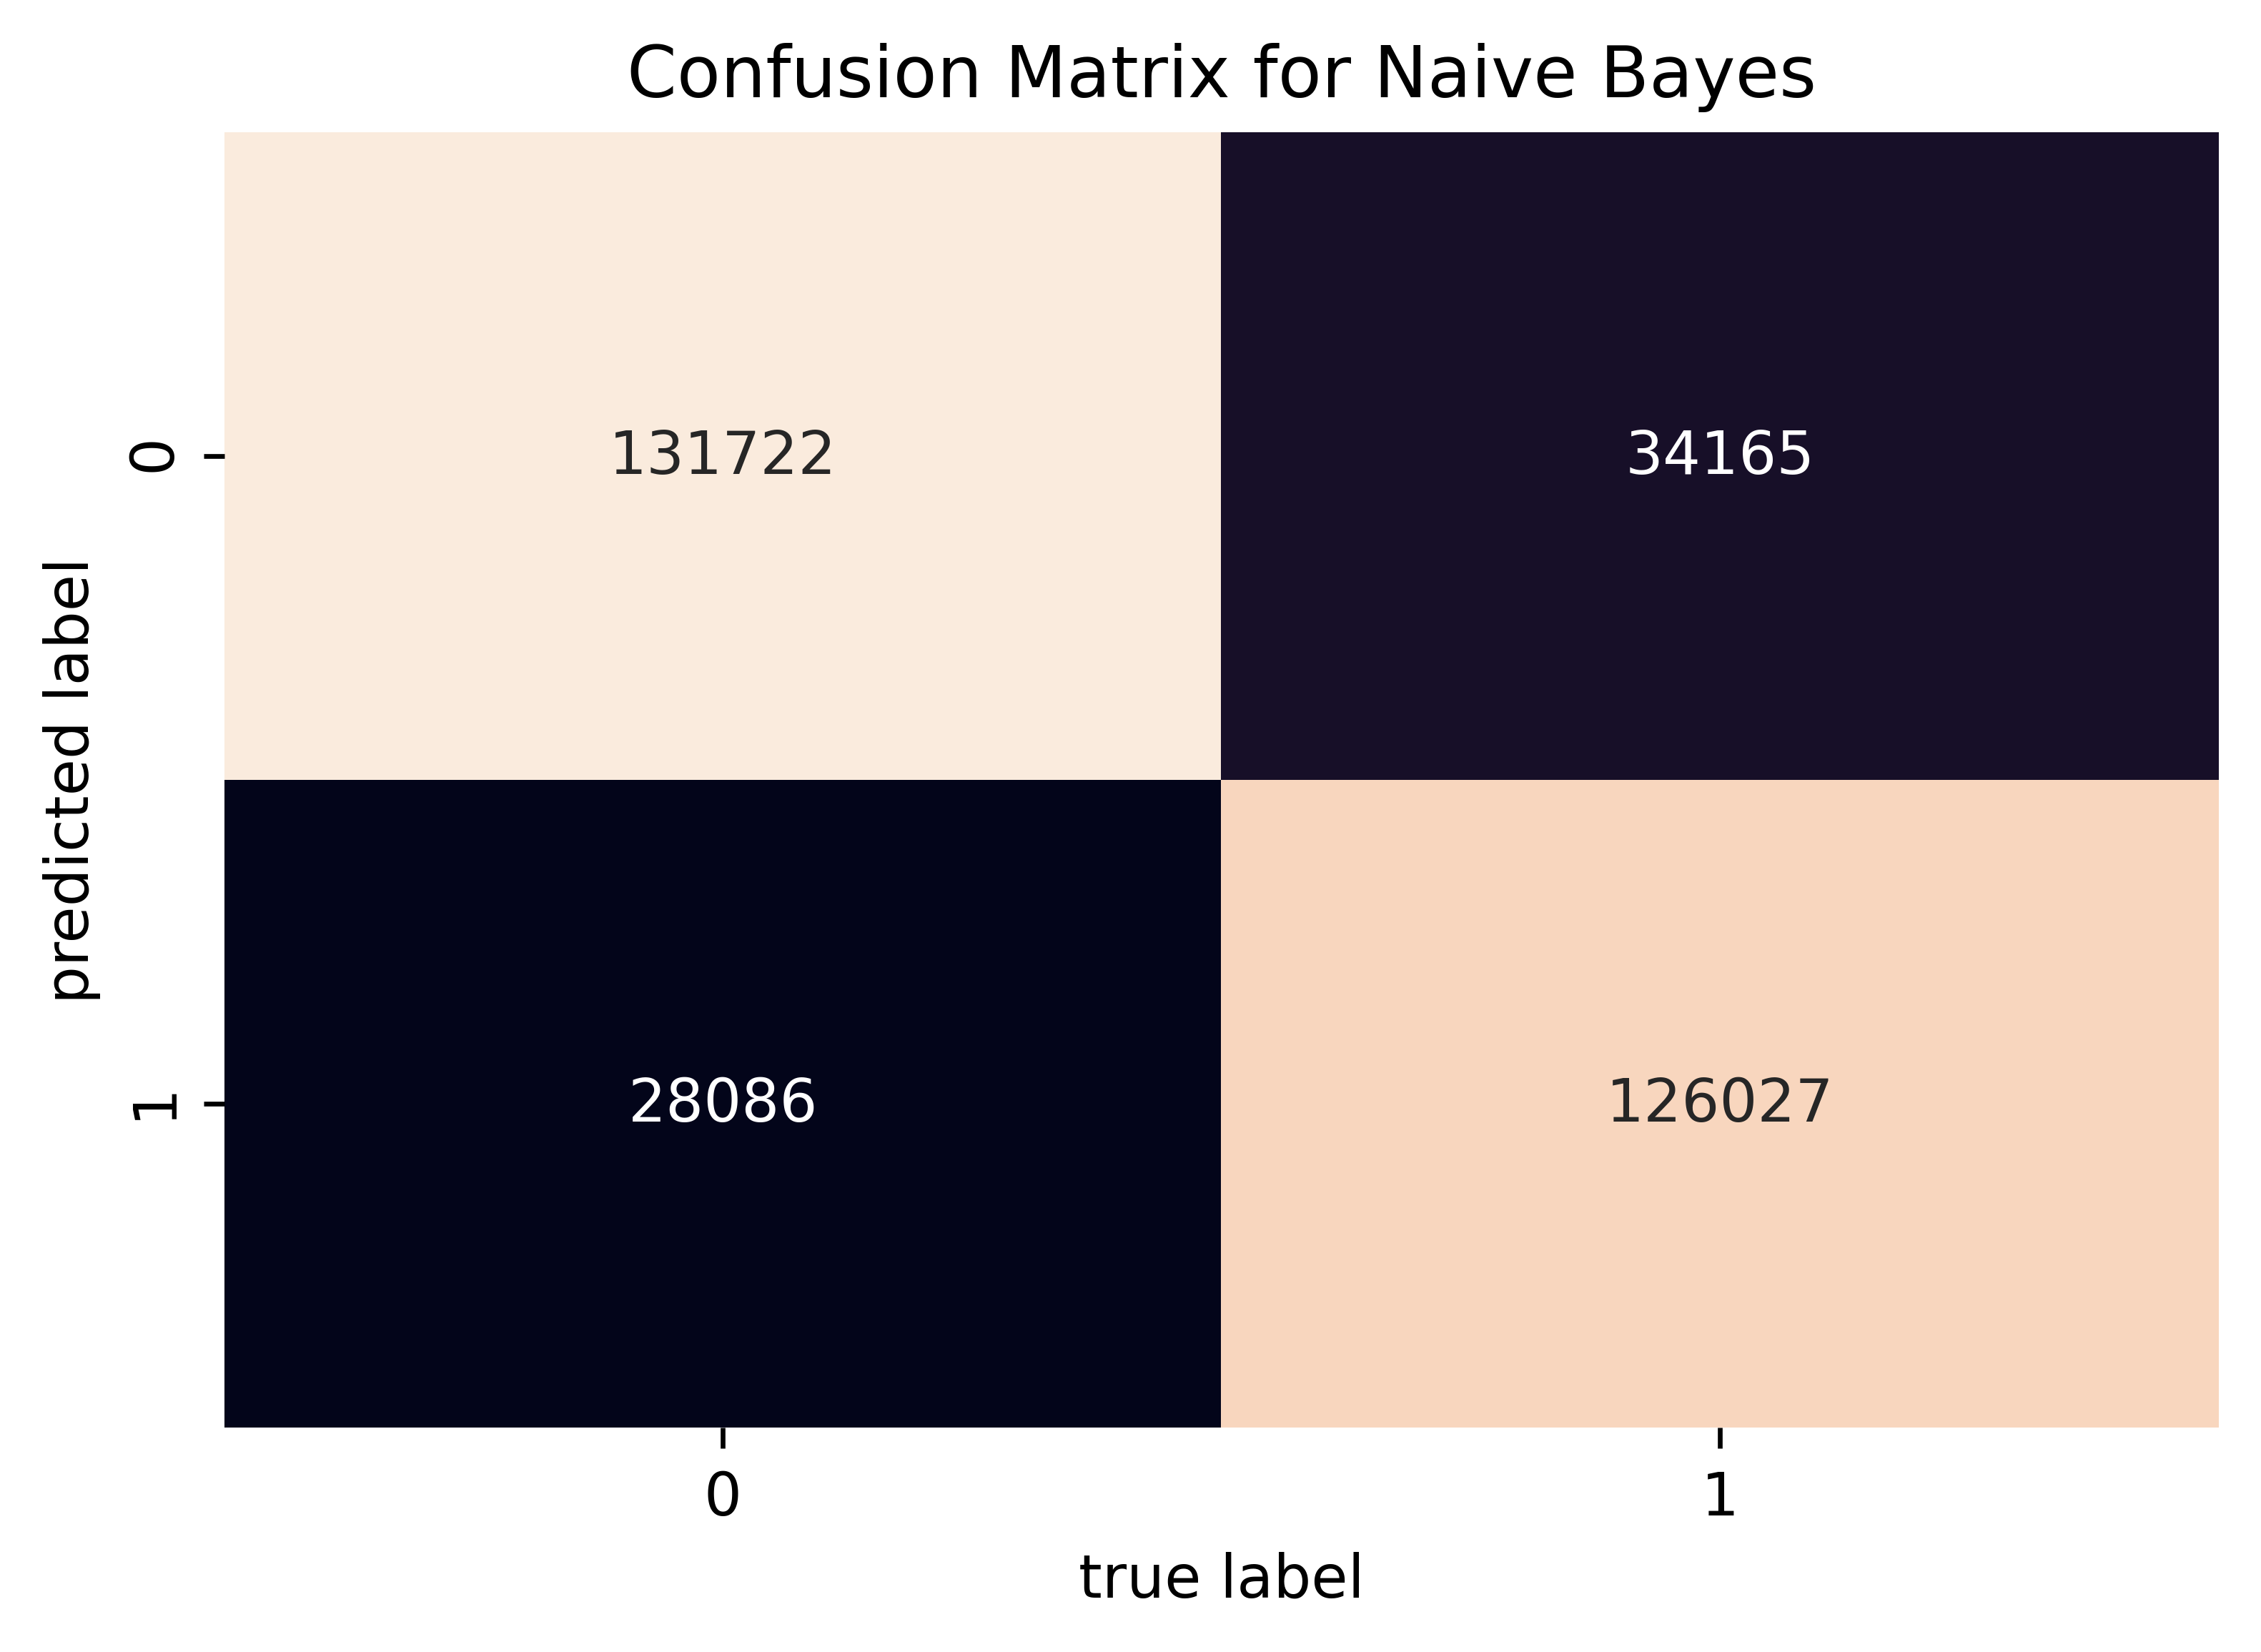

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(dpi=600)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
# plt.savefig("assets/confusion_matrix.png")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Naive-bayes: ",score_naive)

Accuracy with Naive-bayes:  0.805465625


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_naive))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81    159808
           4       0.82      0.79      0.80    160192

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



In [ ]:
from sklearn.model_selection import train_test_split
new_df = df[790000:810000]
train_X1, test_X1, train_Y1, test_Y1 = train_test_split(new_df['text'], new_df['sentiment'], test_size = 0.2, random_state = 0)

Data Split done.


In [ ]:
df_train80 = pd.DataFrame()
df_train80['text'] = train_X1
df_train80['sentiment'] = train_Y1

df_test20 = pd.DataFrame()
df_test20['text'] = test_X1
df_test20['sentiment'] = test_Y1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect_8020 = TfidfVectorizer(max_features = 5000)
tfidf_vect_8020.fit(df['text'])
train_X_tfidf_8020 = tfidf_vect_8020.transform(df_train80['text'])
test_X_tfidf_8020 = tfidf_vect_8020.transform(df_test20['text'])

In [ ]:


print(train_X_tfidf_8020.shape)
print(test_X_tfidf_8020.shape)



(16000, 5000)
(4000, 5000)


In [ ]:
print(tfidf_vect_8020.vocabulary_)

{'http': 2147, 'twitpic': 4548, 'com': 944, 'awww': 399, 'that': 4326, 'bummer': 711, 'you': 4958, 'shoulda': 3847, 'got': 1870, 'david': 1159, 'of': 3058, 'third': 4357, 'day': 1162, 'to': 4415, 'do': 1290, 'it': 2278, 'is': 2271, 'upset': 4621, 'he': 2008, 'can': 759, 'update': 4611, 'his': 2074, 'facebook': 1549, 'by': 735, 'texting': 4313, 'and': 246, 'might': 2789, 'cry': 1088, 'as': 329, 'result': 3589, 'school': 3721, 'today': 4417, 'also': 225, 'blah': 558, 'many': 2690, 'times': 4400, 'for': 1699, 'the': 4328, 'ball': 432, 'managed': 2681, 'save': 3706, '50': 84, 'rest': 3586, 'go': 1841, 'out': 3126, 'my': 2906, 'whole': 4793, 'body': 597, 'feels': 1607, 'itchy': 2281, 'like': 2546, 'its': 2285, 'on': 3083, 'fire': 1646, 'no': 2998, 'not': 3021, 'at': 349, 'all': 212, 'mad': 2657, 'why': 4801, 'am': 229, 'here': 2050, 'because': 481, 'see': 3755, 'over': 3132, 'there': 4341, 'crew': 1074, 'need': 2944, 'hug': 2149, 'hey': 2055, 'long': 2603, 'time': 4399, 'yes': 4945, 'rains'

In [ ]:

from sklearn.svm import SVC

model = SVC(kernel='linear')
model.fit(train_X_tfidf_8020,train_Y1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:

from sklearn.metrics import accuracy_score

predictions_SVM_8020 = model.predict(test_X_tfidf_8020)
test_prediction_8020 = pd.DataFrame()
test_prediction_8020['Sentiment'] = test_X1
test_prediction_8020['Label'] = predictions_SVM_8020
SVM_accuracy_8020 = accuracy_score(predictions_SVM_8020, test_Y1)*100
SVM_accuracy_8020 = round(SVM_accuracy_8020,1)

In [ ]:
SVM_accuracy_8020

77.4

In [ ]:

from sklearn.metrics import classification_report

print ("\nHere is the classification report:") 
print (classification_report(test_Y1, predictions_SVM_8020))


Here is the classification report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1994
           4       0.77      0.77      0.77      2006

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
new_df = df[790000:810000]
train_X1, test_X1, train_Y1, test_Y1 = train_test_split(new_df['text'], new_df['sentiment'], test_size = 0.2, random_state = 0)
df_train80 = pd.DataFrame()
df_train80['text'] = train_X1
df_train80['sentiment'] = train_Y1

df_test20 = pd.DataFrame()
df_test20['text'] = test_X1
df_test20['sentiment'] = test_Y1


tfidf_vect_8020 = TfidfVectorizer(max_features = 5000)
tfidf_vect_8020.fit(df['text'])
train_X_tfidf_8020 = tfidf_vect_8020.transform(df_train80['text'])
test_X_tfidf_8020 = tfidf_vect_8020.transform(df_test20['text'])

X_train = train_X_tfidf_8020
y_train = df_train80['sentiment']

rf1 = RandomForestClassifier(n_estimators=100,max_depth=20)
rf1.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
X_val,y_val = test_X_tfidf_8020,df_test20['sentiment'] 
y_pred = rf1.predict(X_val)
accuracy = round(accuracy_score(y_val,y_pred), 3)
accuracy

0.725

In [ ]:

from sklearn.linear_model import LogisticRegression
X_train = train_X_tfidf_8020
y_train = df_train80['sentiment']
LR = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LR.fit(X_train, y_train)
# model_Evaluate(LR)
X_test,y_test = test_X_tfidf_8020,df_test20['sentiment'] 
y_pred = LR.predict(X_test)
accuracy = round(accuracy_score(y_test,y_pred), 3)
accuracy


0.775

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
new_df = df[790000:810000]
vectorizer = TfidfVectorizer(stop_words = 'english')
data = vectorizer.fit_transform(new_df['text'])

In [ ]:
true_k = 3
clustering_model = KMeans(n_clusters = true_k, 
                          init = 'k-means++',
                          max_iter = 300, n_init = 10)
clustering_model.fit(data)
 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
print("Top terms per cluster:")

sorted_centroids = clustering_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in sorted_centroids[i, :50]:
            print(' %s' % terms[ind], end='')
        print()
        print()
 

Top terms per cluster:
Cluster 0: good morning day night luck hope today just feel time going really like sleep pretty feeling having know home don sounds thanks did quot think better great amp bad start lol im coffee thing world miss new friend bed look twitter far make com got looking tuesday news ll idea

Cluster 1: just today day like quot http going farrah time know sad love don com got really want lol new miss thanks twitter think fawcett im ll oh need home amp great night hope feel sorry tomorrow wish haha sleep bad working getting happy right days nice way better ve make

Cluster 2: work today day ready just getting got going time home want don need doesn tonight really night im good tomorrow hours days till week morning wanna sleep feeling dont hour lol long ll oh working lunch nice bed stuck friday think doing sick little know like amp didn bad wait

